In [93]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math


def filtering_2d(image, kernel, sobel=False):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize the output matrix
    output = np.zeros((output_height, output_width))

    # Apply convolution (slide the kernel over the image)
    for i in range(output_height):
        for j in range(output_width):
            # Element-wise multiplication and sum
            total_sum = np.sum(
                image[i : i + kernel_height, j : j + kernel_width] * kernel
            )
            output[i, j] = total_sum if sobel == False else abs(total_sum)

    return output


def get_grad_mag(matrix_1, matrix_2):
    cols, rows = matrix_1.shape
    output = np.zeros((cols, rows))

    for i in range(cols):
        for j in range(rows):
            pixel_1 = matrix_1[i, j]
            pixel_2 = matrix_2[i, j]
            output[i, j] = math.sqrt(pixel_1**2 + pixel_2**2)

    return output


def get_grad_angle(matrix_1, matrix_2):
    cols, rows = matrix_1.shape
    output = np.zeros((cols, rows))

    for i in range(cols):
        for j in range(rows):
            pixel_1 = matrix_1[i, j]
            pixel_2 = matrix_2[i, j]
            output[i, j] = math.degrees(math.atan2(pixel_2, pixel_1))

    return output


def quantized_angle(gradient_angles):
    height, width = gradient_angles.shape
    gradient_angles = gradient_angles % 180
    result = np.zeros((height, width))

    for h in range(height):
        for w in range(width):
            angle = gradient_angles[h, w]

            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                result[h, w] = 0
            elif 22.5 <= angle < 67.5:
                result[h, w] = 45
            elif 67.5 <= angle < 112.5:
                result[h, w] = 90
            elif 112.5 <= angle < 157.5:
                result[h, w] = 135

    return result


def non_max_suppression(magnitude, angle):
    height, width = magnitude.shape
    suppressed = np.copy(magnitude)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            angle_val = angle[i, j]
            if angle_val == 0:
                if (
                    magnitude[i, j] < magnitude[i, j - 1]
                    or magnitude[i, j] < magnitude[i, j + 1]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 45:
                if (
                    magnitude[i, j] < magnitude[i - 1, j + 1]
                    or magnitude[i, j] < magnitude[i + 1, j - 1]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 90:
                if (
                    magnitude[i, j] < magnitude[i - 1, j]
                    or magnitude[i, j] < magnitude[i + 1, j]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 135:
                if (
                    magnitude[i, j] < magnitude[i - 1, j - 1]
                    or magnitude[i, j] < magnitude[i + 1, j + 1]
                ):
                    suppressed[i, j] = 0
    return suppressed


def hysteresis_thresholding(nms_img, low_threshold, high_threshold):
    # Create a strong pixel mask
    strong_px_mask = (nms_img >= high_threshold).astype(np.uint8)

    # Create a weak pixel mask
    weak_px_mask = (
        (nms_img >= low_threshold) & (nms_img < high_threshold)
    ).astype(np.uint8)

    # Get the dimensions of the image
    height, width = nms_img.shape

    # Create an output image initialized to zeros
    output = np.zeros_like(nms_img, dtype=np.uint8)

    # Set strong edges in the output image
    output[strong_px_mask == 1] = 255

    # Check for weak edges connected to strong edges (8-connectivity)
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if weak_px_mask[i, j] == 1:
                # Check 8-connectivity
                if (
                    strong_px_mask[i - 1, j - 1] == 1
                    or strong_px_mask[i - 1, j] == 1
                    or strong_px_mask[i - 1, j + 1] == 1
                    or strong_px_mask[i, j - 1] == 1
                    or strong_px_mask[i, j + 1] == 1
                    or strong_px_mask[i + 1, j - 1] == 1
                    or strong_px_mask[i + 1, j] == 1
                    or strong_px_mask[i + 1, j + 1] == 1
                ):
                    # Promote weak pixel to strong
                    output[i, j] = 255

    return output

In [ ]:
group_img = Image.open("dataset/group-photo.jpeg")
gray_group_img = group_img.convert('L')

# Convert the image to a NumPy array
img_matrix = np.array(gray_group_img)

# Display the shape and type of the array
print(img_matrix.shape)
print(img_matrix.dtype)
print("img_matrix", img_matrix) 


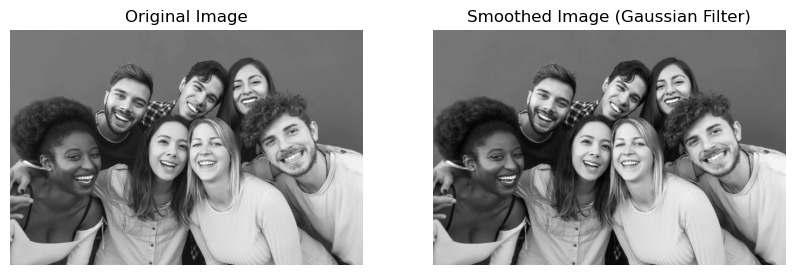

In [23]:
# step 1: Apply Gaussian smoothing on the image.
gaussian_kernel = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
gaussian_blur_custom = filtering_2d(img_matrix, gaussian_kernel)
gaussian_blur_cv2 = cv2.GaussianBlur(img_matrix,(3,3),0)

# print("gaussian_filtering", gaussian_blur_custom, gaussian_blur_custom.shape)

plt.figure(figsize=(10, 5))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_matrix, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blur_custom, cmap='gray')
plt.title('Smoothed Image (Gaussian Filter)')
plt.axis('off')

# Smoothed image cv2
# plt.subplot(1, 2, 2)
# plt.imshow(gaussian_blur_cv2, cmap='gray')
# plt.title('Smoothed Image (Gaussian Filter)')
# plt.axis('off')

plt.show()

gradient_x [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [28. 29. 22. ...  0.  0.  0.]
 [28. 27. 11. ...  0.  0.  0.]
 [28. 25.  3. ...  0.  0.  0.]]
gradient_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [0. 1. 8. ... 0. 0. 0.]
 [0. 1. 7. ... 0. 0. 0.]
 [0. 1. 5. ... 0. 0. 0.]]


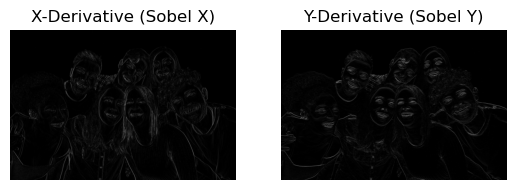

In [24]:
# step 2: Get X, and Y Derivatives using Sobel operator

kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

gradient_x = filtering_2d(img_matrix, kernel_x, True)
gradient_y = filtering_2d(img_matrix, kernel_y, True)

print("gradient_x", gradient_x)
print("gradient_y", gradient_y)

# X-derivative
plt.subplot(1, 2, 1)
plt.imshow(gradient_x, cmap="gray")
plt.title("X-Derivative (Sobel X)")
plt.axis("off")

# Y-derivative
plt.subplot(1, 2, 2)
plt.imshow(gradient_y, cmap="gray")
plt.title("Y-Derivative (Sobel Y)")
plt.axis("off")

plt.show()

# # Apply Gaussian smoothing
# smoothed_image = cv2.GaussianBlur(img_matrix, (3, 3), 0)

# # Compute the x and y derivatives using Sobel filters
# gradient_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
# gradient_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)

# # Convert gradients to 8-bit images for displaying
# gradient_x = cv2.convertScaleAbs(gradient_x)
# gradient_y = cv2.convertScaleAbs(gradient_y)

# # Plot the original, smoothed, x-derivative, and y-derivative images
# plt.figure(figsize=(15, 5))


# # X-derivative
# plt.subplot(1, 2, 1)
# plt.imshow(gradient_x, cmap='gray')
# plt.title('X-Derivative (Sobel X)')
# plt.axis('off')

# # Y-derivative
# plt.subplot(1, 2, 2)
# plt.imshow(gradient_y, cmap='gray')
# plt.title('Y-Derivative (Sobel Y)')
# plt.axis('off')

# plt.show()

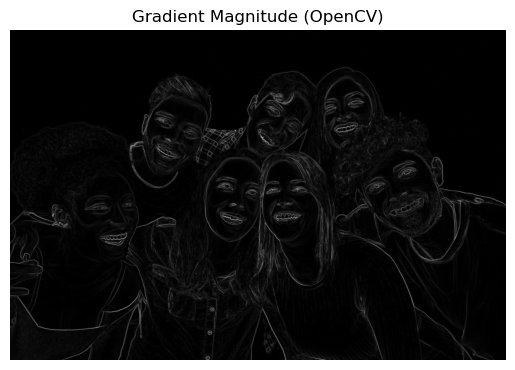

In [68]:
# step 3: compute gradient magnitude

# gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_magnitude = get_grad_mag(gradient_x, gradient_y)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude (OpenCV)')
plt.axis('off')
plt.show()

In [72]:
# step 4: compute gradient angle
gradient_angle = get_grad_mag(gradient_x, gradient_y)
# print("=>", gradient_angle)

# gradient_angle_display = (
#     (gradient_angle - gradient_angle.min())
#     / (gradient_angle.max() - gradient_angle.min())
#     * 255
# )

# gradient_angle_display = gradient_angle_display.astype(np.uint8)

# plt.imshow(gradient_angle_display, cmap='gray')
# plt.title('Gradient Angle (OpenCV)')
# plt.axis('off')
# plt.show()

# gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
# gradient_angle = np.arctan2(gradient_y, gradient_x)  # Angle in radians

# # Convert gradient angle to degrees (optional)
# gradient_angle_degrees = np.degrees(gradient_angle)

# print("=>", gradient_angle_degrees)

# # Normalize to 8-bit image for display
# gradient_angle_display = (
#     (gradient_angle_degrees - gradient_angle_degrees.min())
#     / (gradient_angle_degrees.max() - gradient_angle_degrees.min())
#     * 255
# )
# gradient_angle_display = gradient_angle_display.astype(np.uint8)

# # Plot the gradient angle
# plt.imshow(
#     gradient_angle_display, cmap="gray"
# )  # Use 'hsv' colormap to visualize angles
# plt.title("Gradient Angle (NumPy)")
# plt.axis("off")
# plt.show()

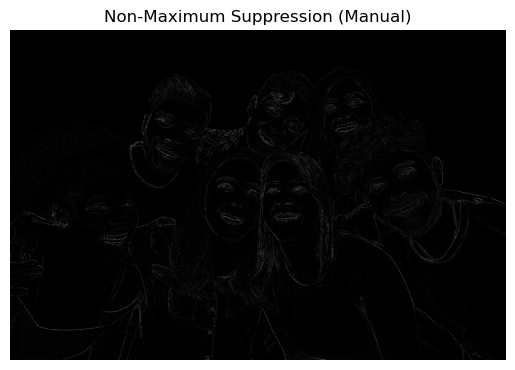

In [79]:
# step 5: Determine NMS (Non Maximum Suppression)
quantized_angles_array = quantized_angle(gradient_angle)

# Perform non-maximum suppression
nms_image = non_max_suppression(gradient_magnitude, quantized_angles_array)

# Normalize to 8-bit for display
nms_image_display = (nms_image / np.max(nms_image) * 255).astype(np.uint8)

# Plot the non-maximum suppressed image
plt.imshow(nms_image_display, cmap="gray")
plt.title("Non-Maximum Suppression (Manual)")
plt.axis("off")
plt.show()

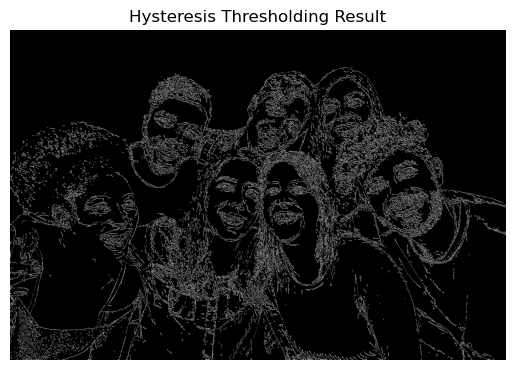

In [94]:
# Define low and high thresholds
low_threshold = 25
high_threshold = 50

# Apply hysteresis thresholding
hysteresis_image = hysteresis_thresholding(nms_image, low_threshold, high_threshold)

# Display the result
plt.imshow(hysteresis_image, cmap='gray')
plt.title('Hysteresis Thresholding Result')
plt.axis('off')
plt.show()